# HW 2.1 Flows in 2D

In [1]:
import os
import pickle

import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

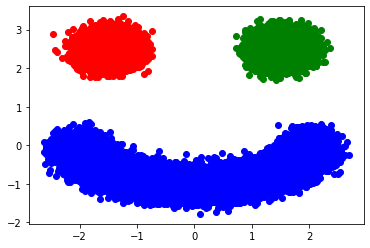

In [2]:
def sample_data():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

xs_all, ys_all = sample_data()

for cls, clr in zip([0, 1, 2], 'rgb'):
    plt.plot(xs_all[ys_all == cls, 0], xs_all[ys_all == cls, 1], clr + 'o')

plt.show()
    
n = xs_all.shape[0]
n_train = int(n * 0.8)
xs_train, ys_train = xs_all[:n_train], ys_all[:n_train]
xs_val, ys_val = xs_all[n_train:], ys_all[n_train:]

In [3]:
batch_size = 100

def collate_fn(data):
    xs, ys = zip(*data)
    xs = torch.tensor(xs, dtype=torch.float32)
    ys = torch.LongTensor(ys)
    return xs, ys

train_data_loader = data.DataLoader(
    dataset=list(zip(xs_train, ys_train)),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
val_data_loader = data.DataLoader(
    dataset=list(zip(xs_val, ys_val)),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

## 1.1 Авторегрессивный Flow

In [4]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, ms=None):
        super().__init__(in_features, out_features, bias)
        
        if not ms:
            mask = np.ones((out_features, in_features))
        else:
            m1, m2 = ms
            mask = m2.reshape(-1, 1) >= m1.reshape(1, -1)
        
        mask = mask.astype(np.float32)
        self.register_buffer('mask', torch.tensor(mask))
        
    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedLinear, self).forward(x)
    

class MADE(nn.Module):
    def __init__(self, input_size, hidden_size=100, n_hidden_layers=1, extension=1):
        super(MADE, self).__init__()
        
        self.input_size = input_size
        self.extension = extension
        
        m = [np.arange(self.input_size) + 1]
        for i in range(n_hidden_layers):
            m += [np.random.randint(m[-1].min(), self.input_size, size=hidden_size)]
        
        layers = [
            MaskedLinear(self.input_size, hidden_size, ms=m[0:2]),
            nn.ReLU()
        ]
        for i in np.arange(1, n_hidden_layers):
            layers += [
                MaskedLinear(hidden_size, hidden_size, ms=m[i:i + 2]),
                nn.ReLU()
            ]
        
        layers += [
            MaskedLinear(
                hidden_size,
                self.input_size * self.extension,
                ms=(m[-1], np.repeat(m[0], self.extension) - 1)
            )
        ]
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.layers(x)
        x = x.view(-1, self.input_size, self.extension)
        return x

In [5]:
class AutoregressiveFlow2D(nn.Module):
    def __init__(self, k):
        super(AutoregressiveFlow2D, self).__init__()
        
        self.pi = nn.Sequential(
            MADE(2, extension=k),
            nn.Softmax(dim=2)
        )
        self.mu = MADE(2, extension=k)
        self.sigma = MADE(2, extension=k)
        
    def forward(self, x):
        pi = self.pi(x)
        mu = self.mu(x)
        sigma = self.sigma(x) ** 2

        dens = pi * torch.exp(-(x.unsqueeze(2) - mu) ** 2 / (2 * sigma)) / (2 * np.pi * sigma) ** 0.5
        dens = dens.sum(dim=2).prod(dim=1)
        
        z = (pi * (torch.erf((x.unsqueeze(2) - mu) / (2 * sigma) ** 0.5) + 1) / 2).sum(dim=2)
        
        return dens, z

Функция ошибки

In [6]:
class MLLELoss(nn.Module):
    eps = 1e-9
    
    def __init__(self):
        super(MLLELoss, self).__init__()

    def forward(self, x):
        loss = -torch.log(x + MLLELoss.eps)
        loss = loss.mean()
        return loss

Функция для тренировки

In [7]:
def train(model, criterion, optimizer, scheduler, epochs):
    losses_train = []
    losses_val = []
    for i in trange(epochs):
        losses = []
        model.train()
        for xs, _ in train_data_loader:
            xs = xs.to(device)
            
            optimizer.zero_grad()

            dens, _ = model(xs)
            loss = criterion(dens)

            losses.append(loss.item())

            loss.backward()
            optimizer.step()

        losses_train.append(np.array(losses).mean())

        losses = []
        model.eval()
        with torch.no_grad():
            for xs, _ in val_data_loader:
                xs = xs.to(device)
                
                dens, _ = model(xs)
                loss = criterion(dens)

                losses.append(loss.item())

        losses_val.append(np.array(losses).mean())
        
        scheduler.step()

    plt.plot(range(epochs), losses_train, label="train")
    plt.plot(range(epochs), losses_val, label="val")
    plt.xlabel('epoch num')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

Расуем двухмерное распределение функции плотности вероятности на квадрате $(-4, 4)^2$

In [8]:
def show_density(model):
    xs = np.linspace(-4, 4, 100)
    xs = np.array(np.meshgrid(xs, xs)).T.reshape([-1, 2])
    xs = torch.tensor(xs, dtype=torch.float32)
    xs = xs.to(device)
    with torch.no_grad():
        dens, _ = model(xs)
        dens = dens.cpu().numpy()
        dens = dens.reshape(100, 100)
        
    dens = np.rot90(dens)
    plt.imshow(dens)
    plt.show()

Отображаем точки датасета в латентное пространство

In [9]:
def show_latent(model):
    xs = torch.tensor(xs_all, dtype=torch.float32)
    xs = xs.to(device)
    with torch.no_grad():
        _, zs = model(xs)
        zs = zs.cpu().numpy()
        
    for cls, clr in zip([0, 1, 2], 'rgb'):
        plt.plot(zs[ys_all == cls, 0], zs[ys_all == cls, 1], clr + 'o')

Переводим сетку прямоугольника $(-4, 4)^2$ в латентное пространство

In [10]:
def show_grid(model):
    coord = np.linspace(-4, 4, 10)
    line = np.linspace(-4, 4, 1000)
    
    grid = np.concatenate([
        np.array(np.meshgrid(coord, line)).T.reshape([-1, 2]),
        np.array(np.meshgrid(line, coord)).T.reshape([-1, 2])
    ])
    
    plt.scatter(grid[:, 0], grid[:, 1], marker='.', s=0.1)
    plt.show()
    
    grid = torch.tensor(grid, dtype=torch.float32)
    grid = grid.to(device)
    with torch.no_grad():
        _, grid = model(grid)
        grid = grid.cpu().numpy()
        
    plt.scatter(grid[:, 0], grid[:, 1], marker='.', s=0.1)
    plt.show()

Обучаем

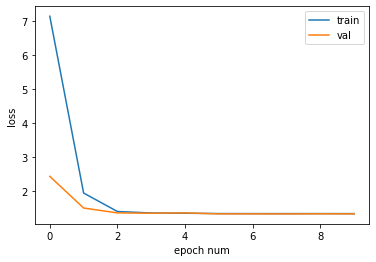

In [11]:
epochs = 10
lr = 0.001
w_l2 = 0

model = AutoregressiveFlow2D(k=10)
model.to(device)

criterion = MLLELoss()

optimizer = optim.Adam(model.parameters(), lr, weight_decay=w_l2)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5], gamma=0.5)

train(model, criterion, optimizer, scheduler, epochs)

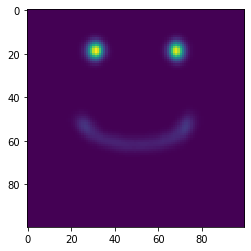

In [12]:
show_density(model)

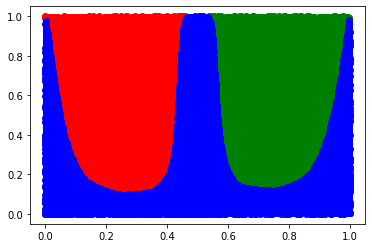

In [13]:
show_latent(model)

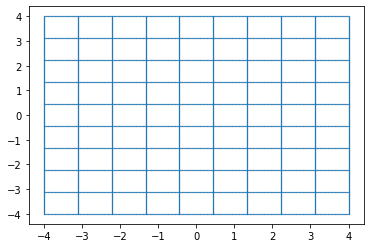

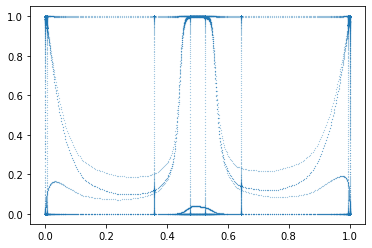

In [14]:
show_grid(model)

## 1.2 RealNVP-like модель

In [15]:
class MLP(nn.Module):
    def __init__(self, hidden_size=100, n_hidden_layers=1):
        super(MLP, self).__init__()
        
        layers = [nn.Linear(2, hidden_size), nn.ReLU()]
        for _ in range(n_hidden_layers):
            layers += [
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            ]
        layers += [nn.Linear(hidden_size, 2)]
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.layers(x)
        return x
    
    
class CouplingLayer(nn.Module):
    def __init__(self, mask, hidden_size=100, n_hidden_layers=1):
        super(CouplingLayer, self).__init__()
        
        self.mask = mask.clone()
        
        self.w = MLP(hidden_size, n_hidden_layers)
        self.b = MLP(hidden_size, n_hidden_layers)
        
    def forward(self, x):
        z = self.mask * x
        w = torch.tanh(self.w(z))
        b = self.b(z)
        logdet = torch.sum((1 - self.mask) * w, dim=1, keepdim=True)
        z = z + (1 - self.mask) * (x * torch.exp(w) + b)
        return logdet, z
            
    def reconstruction(self, x):
        z = self.mask * x
        w = torch.tanh(self.w(z))
        b = self.b(z)
        z = z + (1 - self.mask) * (x - b) * torch.exp(-w)
        return z

In [16]:
class ActNorm(nn.Module):
    EPS = 1e-9
    
    def __init__(self, size):
        super(ActNorm, self).__init__()
        
        self.w = nn.Parameter(torch.ones([1, size]))
        self.b = nn.Parameter(torch.zeros([1, size]))
        
    def forward(self, x):
        x = x * self.w + self.b
        logdet = torch.log(self.w.abs() + ActNorm.EPS).sum(dim=1, keepdim=True)
        return logdet, x
    
    def reconstruction(self, x):
        x = (x - self.b) / self.w
        return x

In [17]:
class RealNVP(nn.Module):
    EPS = 1e-9

    def __init__(self, n_layers=5, hidden_size=100, n_hidden_layers=1):
        super(RealNVP, self).__init__()

        mask = torch.tensor([[0, 1]], dtype=torch.float32)

        self.layers = nn.ModuleList()
        for _ in range(n_layers - 1):
            self.layers.append(CouplingLayer(mask, hidden_size, n_hidden_layers))
            self.layers.append(ActNorm(2))
            mask = 1 - mask

        self.layers.append(CouplingLayer(mask, hidden_size, n_hidden_layers))

    def forward(self, x):
        logdet = torch.zeros([x.shape[0], 1], dtype=torch.float32)
        for layer in self.layers:
            x_logdet, x = layer(x)
            logdet = logdet + x_logdet

        x = torch.sigmoid(x)
        logdet = logdet + torch.log(x * (1 - x) + RealNVP.EPS).sum(dim=1, keepdim=True)

        return torch.exp(logdet), x

    def reconstruction(self, x):
        z = -torch.log(1 / x - 1)
        for layer in reversed(self.layers):
            z = layer.reconstruction(z)

        return z

Обучаем

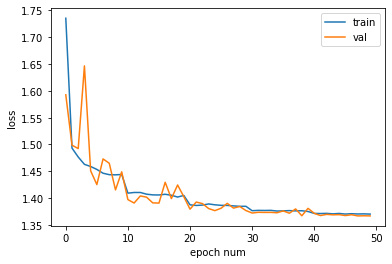

In [18]:
epochs = 50
lr = 0.001
w_l2 = 0

model = RealNVP()
model.to(device)

criterion = MLLELoss()

optimizer = optim.Adam(model.parameters(), lr, weight_decay=w_l2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train(model, criterion, optimizer, scheduler, epochs)

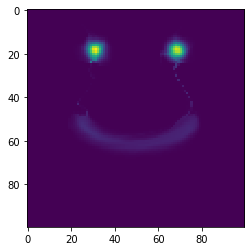

In [19]:
show_density(model)

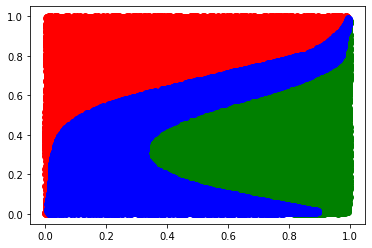

In [20]:
show_latent(model)

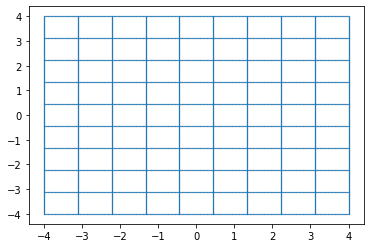

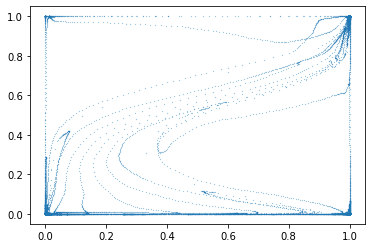

In [21]:
show_grid(model)